▶️ Written result image to tracks_families.png


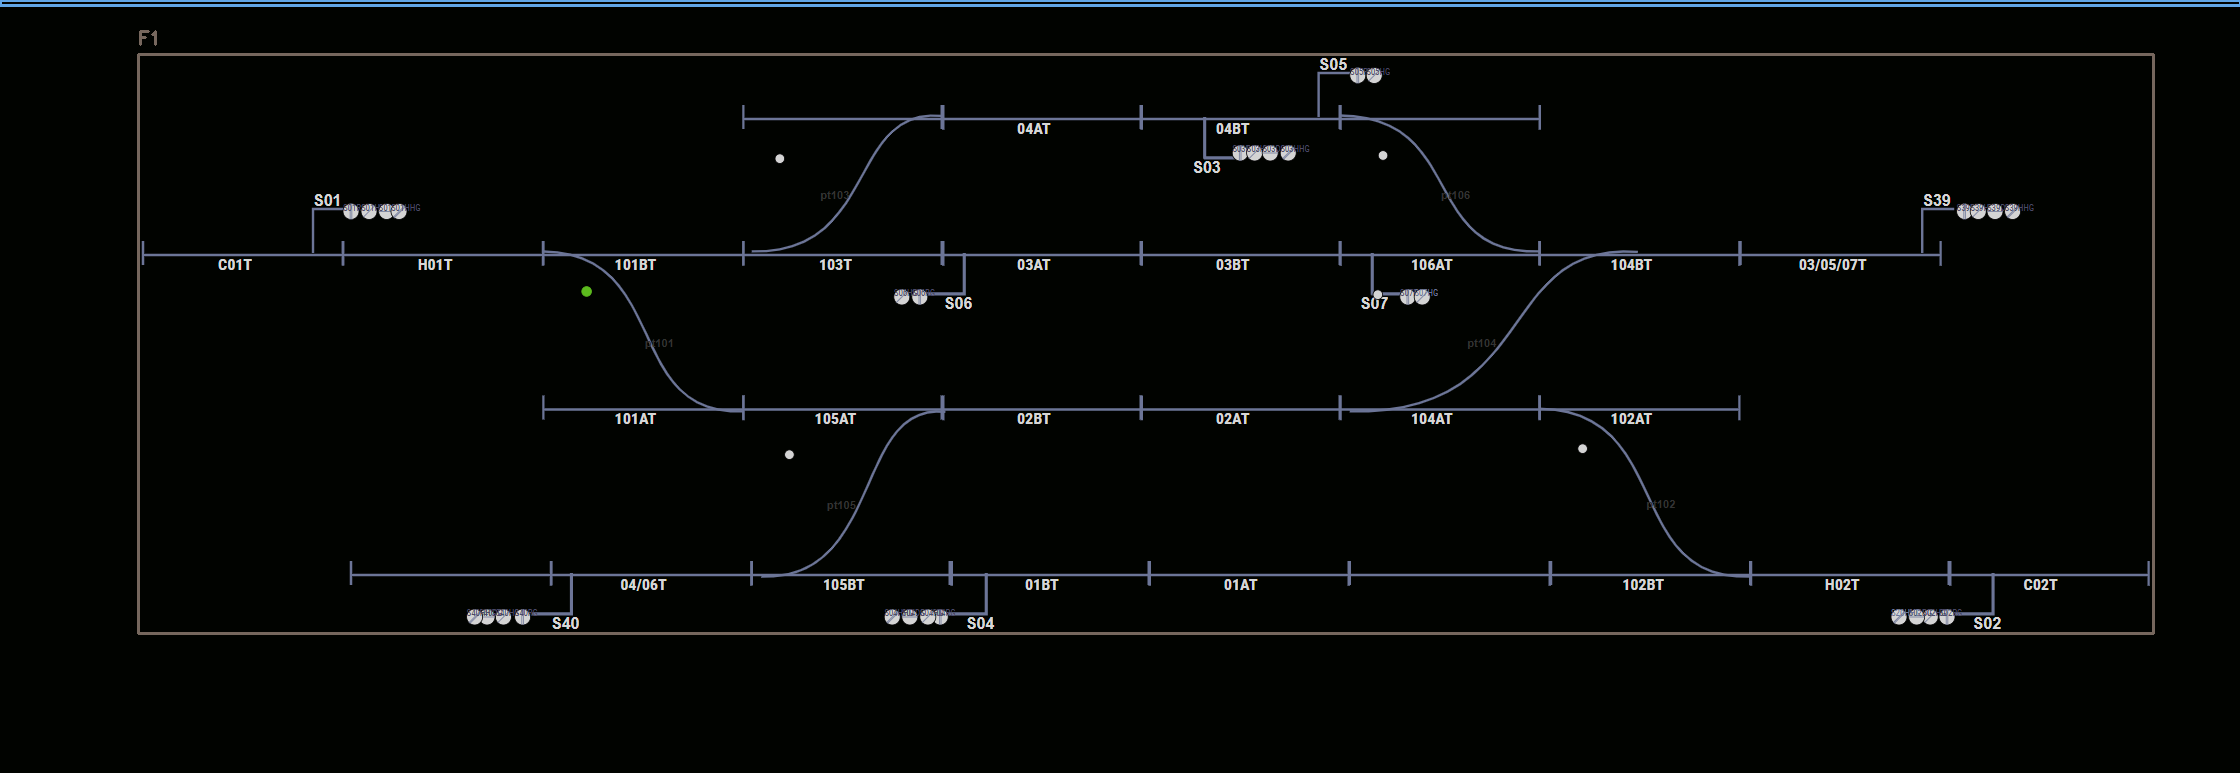

In [ ]:
import cv2
import numpy as np
import random
import math
import os

# ─── Colab‐compatible imshow detection ───────────────────────────────────────────
try:
    from google.colab.patches import cv2_imshow
    use_colab_imshow = True
except ImportError:
    import matplotlib.pyplot as plt
    use_colab_imshow = False

# ─── CONFIGURATION ──────────────────────────────────────────────────────────────

# Path to your real railway-track image
RAW_IMAGE_PATH    = "/content/Screenshot 2025-06-19 192146.png"

# Preprocessing parameters
GAUSSIAN_BLUR_K   = (5,5)     # kernel size for blur
CLAHE_CLIP_LIMIT  = 2.0       # contrast limit for CLAHE
CLAHE_TILE_GRID   = (8,8)     # tile grid size for CLAHE

# Morphological (thickening) parameters
DILATION_KERNEL   = (7,7)     # size to thicken the tracks
DILATION_ITERS    = 1

# Contour filtering
MIN_CONTOUR_AREA  = 500       # ignore tiny blobs

# Grouping (family) threshold
DISTANCE_THRESH   = 20        # pixels: boxes within this distance are in same family

# ─── STEP 1: PREPROCESS ─────────────────────────────────────────────────────────

def preprocess(img_bgr):
    """Convert to grayscale, denoise, and enhance contrast."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, GAUSSIAN_BLUR_K, 0)
    clahe = cv2.createCLAHE(
        clipLimit=CLAHE_CLIP_LIMIT,
        tileGridSize=CLAHE_TILE_GRID
    )
    enhanced = clahe.apply(blur)
    return enhanced

# ─── STEP 2: THICKEN ────────────────────────────────────────────────────────────

def thicken(gray_img):
    """Binary threshold + dilation to make tracks thicker."""
    _, binarized = cv2.threshold(
        gray_img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, DILATION_KERNEL
    )
    dilated = cv2.dilate(binarized, kernel, iterations=DILATION_ITERS)
    return dilated

# ─── STEP 3a: EXTRACT BOUNDING BOXES ─────────────────────────────────────────────

def get_bounding_boxes(binary_img):
    """Find external contours and return bounding boxes of sufficient area."""
    cnts, _ = cv2.findContours(
        binary_img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    boxes = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w * h >= MIN_CONTOUR_AREA:
            boxes.append((x,y,w,h))
    return boxes

# ─── UTILS ──────────────────────────────────────────────────────────────────────

def box_distance(a,b):
    """Minimum edge‐to‐edge distance between two boxes a,b = (x,y,w,h)."""
    x1,y1,w1,h1 = a
    x2,y2,w2,h2 = b
    dx = max(x2 - (x1+w1), x1 - (x2+w2), 0)
    dy = max(y2 - (y1+h1), y1 - (y2+h2), 0)
    return math.hypot(dx, dy)

def group_into_families(boxes):
    """
    Greedy grouping: for each box, pull in any other box
    whose distance ≤ DISTANCE_THRESH.
    """
    used = set()
    families = []
    for i, b in enumerate(boxes):
        if i in used:
            continue
        fam = [b]
        used.add(i)
        for j, c in enumerate(boxes):
            if j in used:
                continue
            if box_distance(b, c) <= DISTANCE_THRESH:
                fam.append(c)
                used.add(j)
        families.append(fam)
    return families

def random_colors(n):
    """Generate n distinct BGR colors."""
    return [tuple(random.choices(range(50,256), k=3)) for _ in range(n)]

# ─── MAIN ───────────────────────────────────────────────────────────────────────

def main():
    # 1) Load & preprocess
    img = cv2.imread(RAW_IMAGE_PATH)
    if img is None:
        raise FileNotFoundError(f"Could not load '{RAW_IMAGE_PATH}'")
    pre = preprocess(img)

    # 2) Thicken tracks
    thick = thicken(pre)

    # 3a) Get bounding boxes
    boxes = get_bounding_boxes(thick)

    # 3b) Group into families
    families = group_into_families(boxes)

    # Visualization
    out_img = img.copy()
    colors = random_colors(len(families))
    for idx, fam in enumerate(families):
        for (x,y,w,h) in fam:
            cv2.rectangle(out_img, (x,y), (x+w,y+h), colors[idx], 2)
        # Label family number at the top-left of first box
        lx, ly, _, _ = fam[0]
        cv2.putText(
            out_img, f"F{idx+1}",
            (lx, ly-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6,
            colors[idx], 2
        )

    # Save result
    out_path = "tracks_families.png"
    cv2.imwrite(out_path, out_img)
    print(f"▶️ Written result image to {out_path}")

    # Display in‐notebook or window
    if use_colab_imshow:
        cv2_imshow(out_img)
    else:
        rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,8))
        plt.axis("off")
        plt.imshow(rgb)
        plt.show()

if __name__ == "__main__":
    main()


Detected 2 track segments (boxes).

Families (neighbors by box index):
  Box 0: connected to []
  Box 1: connected to []

▶️  Written visualization to 'tracks_output.png'


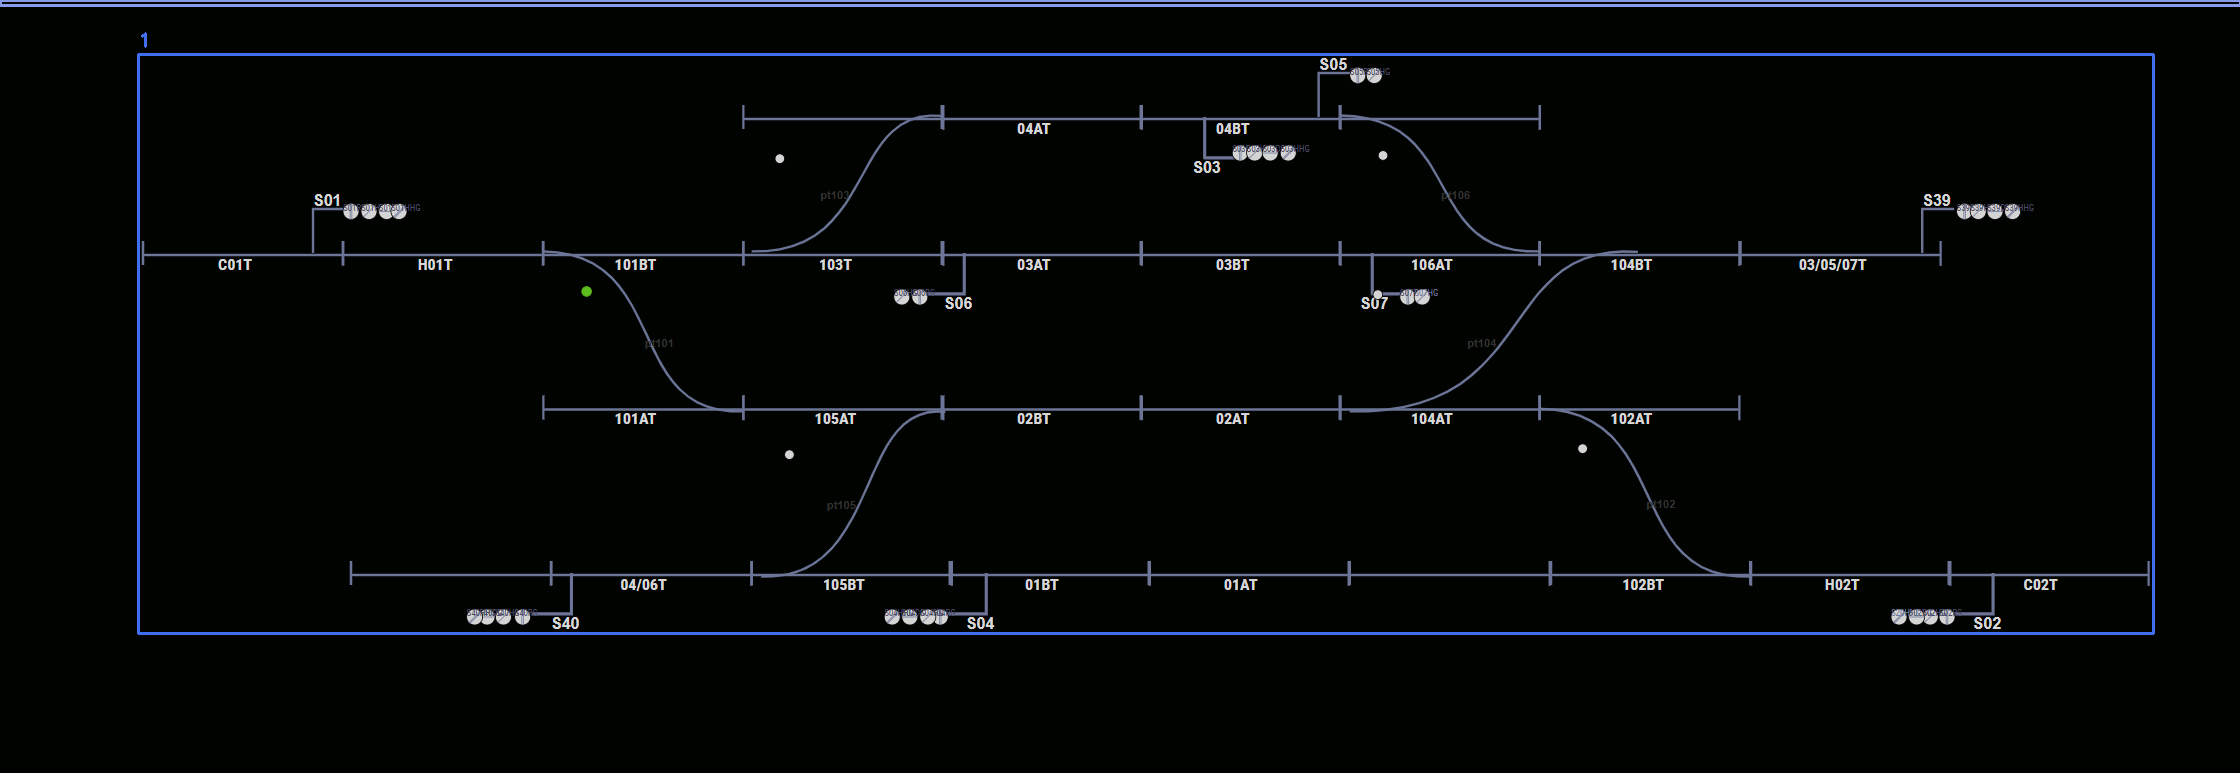

In [ ]:
import cv2
import numpy as np
import math
import random
import os

# ─── Colab‐compatible imshow detection ───────────────────────────────────────────
try:
    from google.colab.patches import cv2_imshow
    use_colab_imshow = True
except ImportError:
    import matplotlib.pyplot as plt
    use_colab_imshow = False

# ─── CONFIGURATION ──────────────────────────────────────────────────────────────

RAW_IMAGE_PATH   = "/content/Screenshot 2025-06-19 192146.png"   # your input image
OUT_IMAGE_PATH   = "tracks_output.png"

# preprocessing
GAUSSIAN_BLUR_K  = (5,5)
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID  = (8,8)

# dilation (to make lines fatter so contours close)
DILATION_KERNEL  = (7,7)
DILATION_ITERS   = 1

# ignore tiny blobs
MIN_CONTOUR_AREA = 500

# if two boxes are within this many pixels edge-to-edge, we call them connected
DISTANCE_THRESH  = 20

# ─── STEP 1: PREPROCESS ─────────────────────────────────────────────────────────

def preprocess(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, GAUSSIAN_BLUR_K, 0)
    clahe = cv2.createCLAHE(
        clipLimit=CLAHE_CLIP_LIMIT,
        tileGridSize=CLAHE_TILE_GRID
    )
    return clahe.apply(blur)

# ─── STEP 2: THICKEN ────────────────────────────────────────────────────────────

def thicken(gray):
    _, binary = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kern = cv2.getStructuringElement(cv2.MORPH_RECT, DILATION_KERNEL)
    return cv2.dilate(binary, kern, iterations=DILATION_ITERS)

# ─── STEP 3: EXTRACT BOXES ───────────────────────────────────────────────────────

def get_bounding_boxes(bin_img):
    cnts, _ = cv2.findContours(
        bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    boxes = []
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        if w*h >= MIN_CONTOUR_AREA:
            boxes.append((x,y,w,h))
    # sort left to right:
    boxes.sort(key=lambda b: b[0])
    return boxes

# ─── UTILS ──────────────────────────────────────────────────────────────────────

def box_distance(a,b):
    # edge-to-edge Euclidean distance
    x1,y1,w1,h1 = a
    x2,y2,w2,h2 = b
    dx = max(x2 - (x1+w1), x1 - (x2+w2), 0)
    dy = max(y2 - (y1+h1), y1 - (y2+h2), 0)
    return math.hypot(dx, dy)

def build_adjacency(boxes):
    n = len(boxes)
    adj = {i: [] for i in range(n)}
    for i in range(n):
        for j in range(i+1, n):
            if box_distance(boxes[i], boxes[j]) <= DISTANCE_THRESH:
                adj[i].append(j)
                adj[j].append(i)
    return adj

def random_colors(n):
    return [tuple(random.choices(range(50,256), k=3)) for _ in range(n)]

# ─── MAIN ───────────────────────────────────────────────────────────────────────

def main():
    img = cv2.imread(RAW_IMAGE_PATH)
    if img is None:
        raise FileNotFoundError(f"Could not load '{RAW_IMAGE_PATH}'")

    # 1) preprocess
    pre = preprocess(img)

    # 2) thicken
    thick = thicken(pre)

    # 3) get one box per track, sorted left->right
    boxes = get_bounding_boxes(thick)
    print(f"Detected {len(boxes)} track segments (boxes).")

    # 4) build adjacency: which boxes are “directly connected”
    adj = build_adjacency(boxes)

    # 5) print families
    print("\nFamilies (neighbors by box index):")
    for i, neigh in adj.items():
        print(f"  Box {i}: connected to {neigh}")

    # 6) visualize
    out = img.copy()
    cols = random_colors(len(boxes))
    for i, (x,y,w,h) in enumerate(boxes):
        color = cols[i]
        cv2.rectangle(out, (x,y), (x+w, y+h), color, 2)
        cv2.putText(out, str(i), (x, y-8),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    cv2.imwrite(OUT_IMAGE_PATH, out)
    print(f"\n▶️  Written visualization to '{OUT_IMAGE_PATH}'")

    if use_colab_imshow:
        cv2_imshow(out)
    else:
        rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,6))
        plt.axis("off")
        plt.imshow(rgb)
        plt.show()

if __name__ == "__main__":
    main()


Found 14 horizontal segments.
→ Grouped into 6 rows of tracks.
Generated 14 per-segment boxes.
Extracted 7 families (connected groups).
  Segment 0 ↔ []
  Segment 1 ↔ [2]
  Segment 2 ↔ [1]
  Segment 3 ↔ [4, 5]
  Segment 4 ↔ [3]
  Segment 5 ↔ [3]
  Segment 6 ↔ []
  Segment 7 ↔ [8]
  Segment 8 ↔ [7, 9]
  Segment 9 ↔ [8]
  Segment 10 ↔ [11, 12]
  Segment 11 ↔ [10, 12]
  Segment 12 ↔ [10, 11]
  Segment 13 ↔ []
Wrote per-segment boxes → tracks_segments.png
Wrote per-family boxes → tracks_output.png


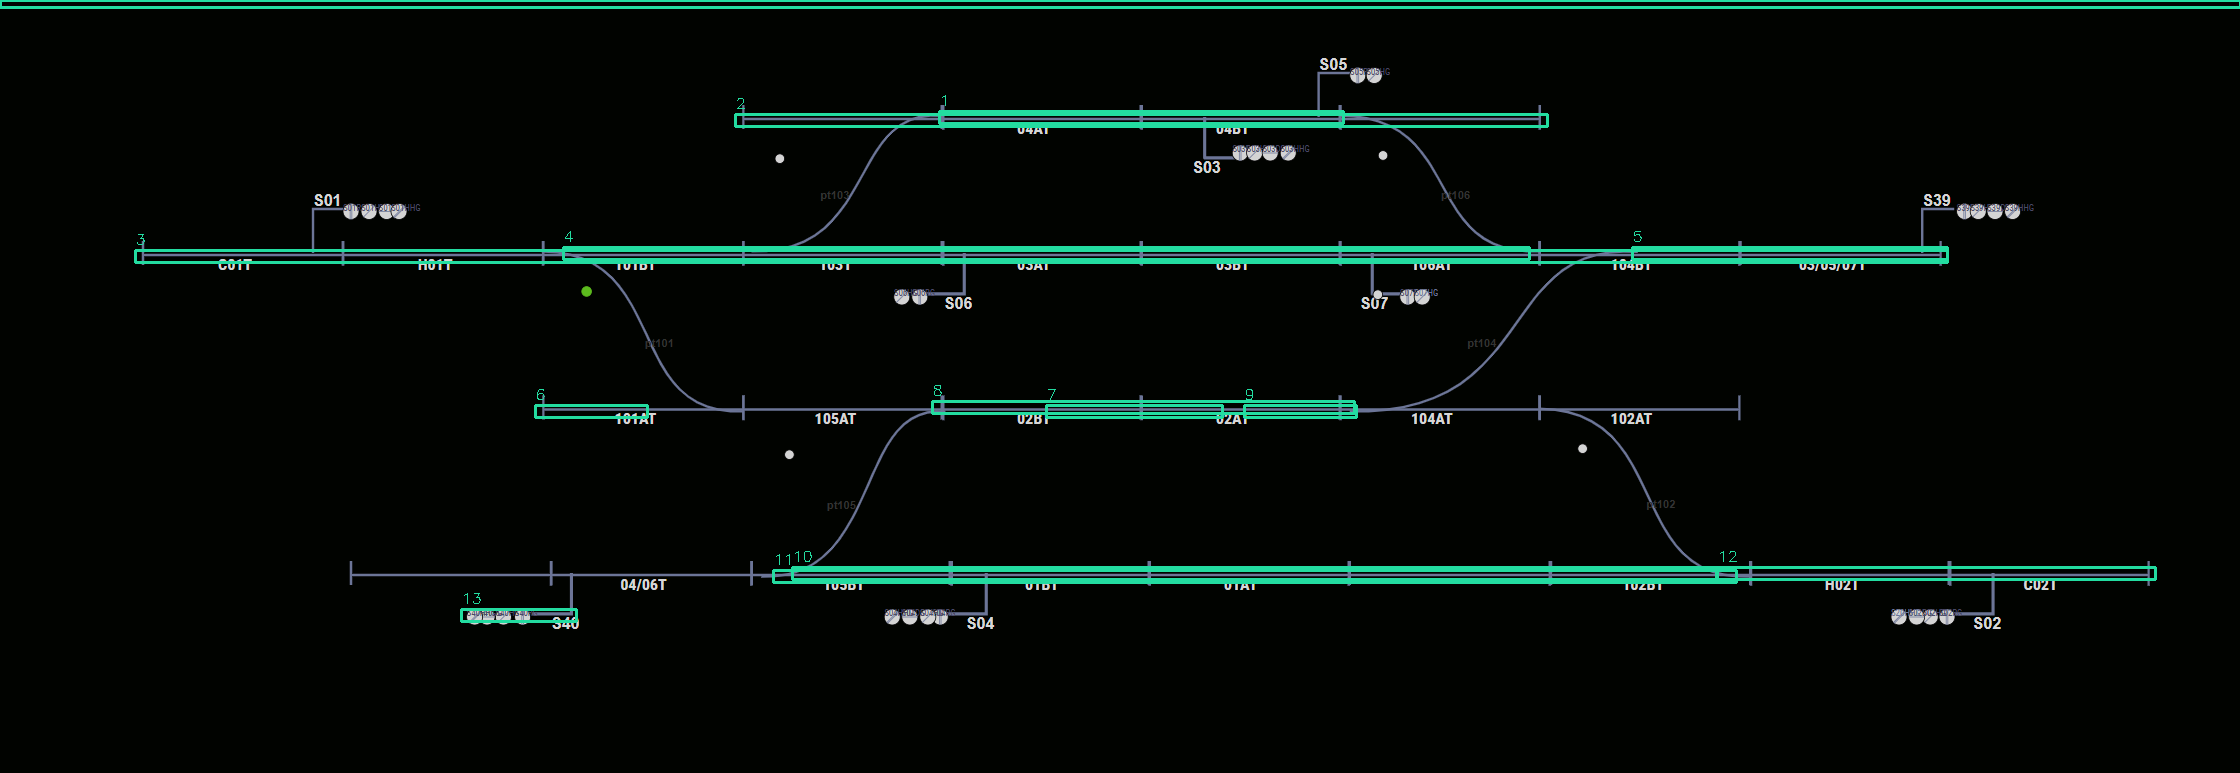

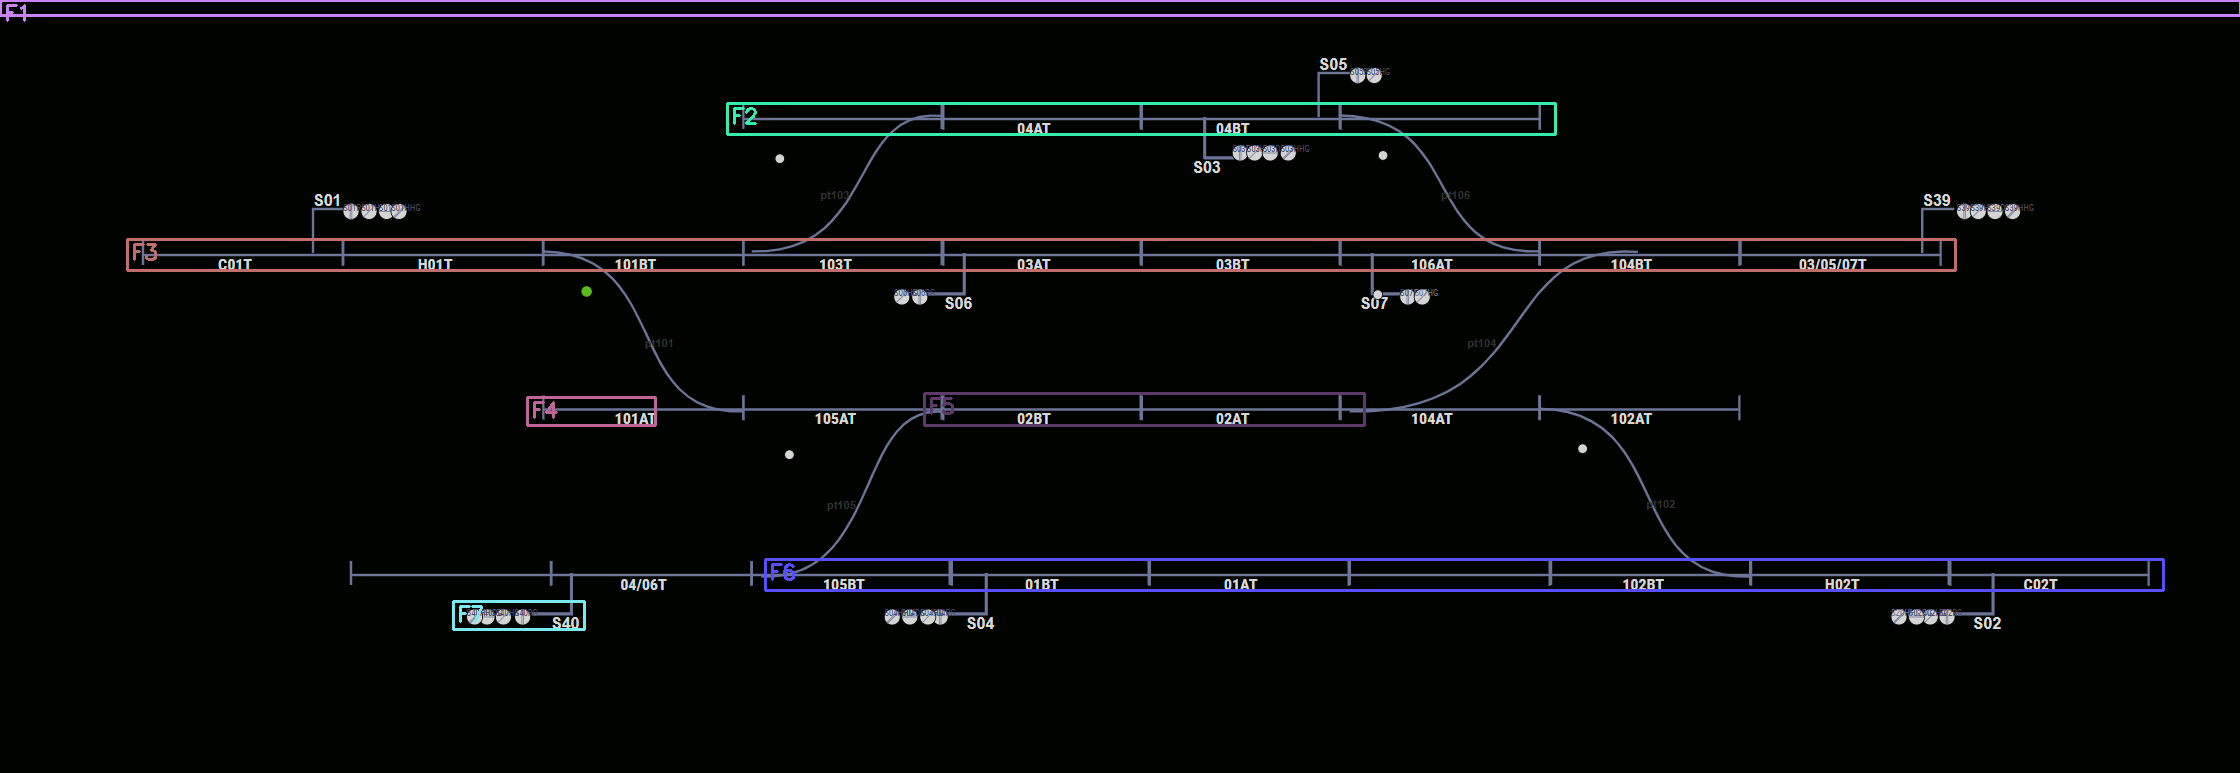

In [ ]:
import cv2
import numpy as np
import math
import random
import os

# ─── Colab‐compatible imshow detection ───────────────────────────────────────────
try:
    from google.colab.patches import cv2_imshow
    use_colab_imshow = True
except ImportError:
    import matplotlib.pyplot as plt
    use_colab_imshow = False

# ─── CONFIG ──────────────────────────────────────────────────────────────────────

RAW_IMAGE_PATH = "/content/Screenshot 2025-06-19 192146.png"
OUT_SEG_IMG    = "tracks_segments.png"
OUT_FAM_IMG    = "tracks_output.png"

# preprocessing
BLUR_KSIZE      = (5,5)
CLAHE_CLIP      = 2.0
CLAHE_GRID      = (8,8)

# Canny
CANNY_LOW       = 50
CANNY_HIGH      = 150

# Hough
HOUGH_THRESH    = 80
MIN_LINE_LEN    = 100
MAX_LINE_GAP    = 10

# “Nearly horizontal” threshold
SLOPE_THRESH    = math.tan(math.radians(5))  # ~0.0875

# Cluster rows by Y-distance
Y_CLUSTER_DIST  = 12

# Padding around each segment
PAD_X, PAD_Y    = 6, 6

# Adjacency threshold for families
DIST_THRESH     = 20

# ─── 1) PREPROCESS ───────────────────────────────────────────────────────────────

def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, BLUR_KSIZE, 0)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP,
                            tileGridSize=CLAHE_GRID)
    return clahe.apply(blur)

# ─── 2) DETECT HORIZONTAL LINE SEGMENTS ──────────────────────────────────────────

def find_horiz_segments(img):
    edges = cv2.Canny(img, CANNY_LOW, CANNY_HIGH, apertureSize=3)
    raw = cv2.HoughLinesP(edges,
                          rho=1,
                          theta=np.pi/180,
                          threshold=HOUGH_THRESH,
                          minLineLength=MIN_LINE_LEN,
                          maxLineGap=MAX_LINE_GAP)
    if raw is None:
        return []
    segs = raw.reshape(-1,4)
    horiz = []
    for x1,y1,x2,y2 in segs:
        dx, dy = x2-x1, y2-y1
        if dx!=0 and abs(dy/dx)<SLOPE_THRESH:
            horiz.append((x1,y1,x2,y2))
    return horiz

# ─── 3) CLUSTER INTO ROWS ───────────────────────────────────────────────────────

def cluster_rows(segments):
    """
    Group line-segments by their midpoint‐y into separate rows.
    """
    rows = []
    for seg in sorted(segments, key=lambda s: (s[1]+s[3])/2):
        midy = (seg[1]+seg[3])/2
        placed=False
        for row in rows:
            # compare to the row's average midpoint
            avg = np.mean([(r[1]+r[3])/2 for r in row])
            if abs(midy-avg)<Y_CLUSTER_DIST:
                row.append(seg)
                placed=True
                break
        if not placed:
            rows.append([seg])
    return rows

# ─── 4) MAKE ONE BOX PER SEGMENT ────────────────────────────────────────────────

def segments_to_boxes(rows, img_shape):
    """
    rows: list of lists of (x1,y1,x2,y2)
    Returns: list of (x,y,w,h), sorted by row top→bottom, then left→right
    """
    H, W = img_shape[:2]
    boxes = []
    for row in rows:
        # sort this row left→right by midpoint‐x
        row.sort(key=lambda s: (s[0]+s[2])/2)
        for x1,y1,x2,y2 in row:
            x_min = max(0, min(x1,x2)-PAD_X)
            y_min = max(0, min(y1,y2)-PAD_Y)
            x_max = min(W, max(x1,x2)+PAD_X)
            y_max = min(H, max(y1,y2)+PAD_Y)
            boxes.append((x_min, y_min, x_max-x_min, y_max-y_min))
    return boxes

# ─── 5) BUILD ADJACENCY (FAMILIES) ───────────────────────────────────────────────

def box_dist(a,b):
    x1,y1,w1,h1 = a
    x2,y2,w2,h2 = b
    dx = max(x2-(x1+w1), x1-(x2+w2), 0)
    dy = max(y2-(y1+h1), y1-(y2+h2), 0)
    return math.hypot(dx, dy)

def build_adj(boxes):
    n = len(boxes)
    adj = {i:[] for i in range(n)}
    for i in range(n):
        for j in range(i+1,n):
            if box_dist(boxes[i],boxes[j])<=DIST_THRESH:
                adj[i].append(j)
                adj[j].append(i)
    return adj

def extract_families(adj):
    seen=set()
    fams=[]
    for i in adj:
        if i in seen:
            continue
        stack=[i]; comp=set()
        while stack:
            u=stack.pop()
            if u in comp: continue
            comp.add(u)
            for v in adj[u]:
                if v not in comp:
                    stack.append(v)
        seen |= comp
        fams.append(sorted(comp))
    return fams

# ─── UTILS ──────────────────────────────────────────────────────────────────────

def random_colors(n):
    return [tuple(random.choices(range(50,256),k=3)) for _ in range(n)]

# ─── MAIN ───────────────────────────────────────────────────────────────────────

def main():
    img = cv2.imread(RAW_IMAGE_PATH)
    if img is None:
        raise FileNotFoundError(f"Could not load '{RAW_IMAGE_PATH}'")

    # preprocess
    pre = preprocess(img)

    # detect horizontal segments
    segs = find_horiz_segments(pre)
    print(f"Found {len(segs)} horizontal segments.")

    # cluster into rows
    rows = cluster_rows(segs)
    print(f"→ Grouped into {len(rows)} rows of tracks.")

    # one bbox per segment
    boxes = segments_to_boxes(rows, img.shape)
    print(f"Generated {len(boxes)} per-segment boxes.")

    # adjacency & families
    adj  = build_adj(boxes)
    fams = extract_families(adj)
    print(f"Extracted {len(fams)} families (connected groups).")
    for i,nb in adj.items():
        print(f"  Segment {i} ↔ {nb}")

    # ─ draw per-segment boxes (yellow)
    seg_out = img.copy()
    for i,(x,y,w,h) in enumerate(boxes):
        cv2.rectangle(seg_out, (x,y), (x+w,y+h),
                      (160,220,35), 2)
        cv2.putText(seg_out,str(i),(x,y-6),
                    cv2.FONT_HERSHEY_SIMPLEX,0.5,
                    (160,220,35),1)
    cv2.imwrite(OUT_SEG_IMG, seg_out)
    print(f"Wrote per-segment boxes → {OUT_SEG_IMG}")

    # ─ draw per-family outer boxes (random colors)
    fam_out = img.copy()
    colors = random_colors(len(fams))
    P = 8
    for fid,comp in enumerate(fams):
        xs,ys,ws,hs = [],[],[],[]
        for i in comp:
            x,y,w,h = boxes[i]
            xs.append(x); ys.append(y)
            ws.append(w); hs.append(h)
        x0 = max(0,   min(xs)-P)
        y0 = max(0,   min(ys)-P)
        x1 = min(img.shape[1], max(x+ w for x,w in zip(xs,ws))+P)
        y1 = min(img.shape[0], max(y+ h for y,h in zip(ys,hs))+P)
        c=colors[fid]
        cv2.rectangle(fam_out,(x0,y0),(x1,y1),c,2)
        cv2.putText(fam_out,f"F{fid+1}",(x0+4,y0+20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.7,c,2)

    cv2.imwrite(OUT_FAM_IMG, fam_out)
    print(f"Wrote per-family boxes → {OUT_FAM_IMG}")

    # display segment result
    if use_colab_imshow:
        cv2_imshow(seg_out)
    else:
        plt.figure(figsize=(12,5)); plt.imshow(cv2.cvtColor(seg_out,cv2.COLOR_BGR2RGB))
        plt.axis("off"); plt.show()

    # display family result
    if use_colab_imshow:
        cv2_imshow(fam_out)
    else:
        plt.figure(figsize=(12,5)); plt.imshow(cv2.cvtColor(fam_out,cv2.COLOR_BGR2RGB))
        plt.axis("off"); plt.show()


if __name__=="__main__":
    main()
